In [1]:
! pip install scikit-learn -Uqq

In [2]:
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud
!pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 6544, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 6544 (delta 46), reused 91 (delta 38), pack-reused 6441
Receiving objects: 100% (6544/6544), 116.94 MiB | 19.53 MiB/s, done.
Resolving deltas: 100% (3877/3877), done.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import files
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from nltk.corpus import stopwords as stpw
import nltk

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import pickle

## Load data
The training/evaluation data is a random sample of 3000 records manually labeled obtained from GBIF.

The field notes are in the column `Fieldnotes`, and labels for the fieldnotes are in the `Label_Flowering` and `Label_Fruiting`. Also, there are labels for images in the columns `Image_flowering` and `Image_fruiting`.

In [4]:
uploaded = files.upload()

Saving Stratified_val_df_img_nondup_def.csv to Stratified_val_df_img_nondup_def.csv


In [5]:
filename = "Stratified_val_df_img_nondup_def.csv" # this must match the name of the file you uploaded
df = pd.read_csv(io.StringIO(uploaded[filename].decode("utf-8")))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gbifID                          3000 non-null   int64  
 1   institutionCode                 3000 non-null   object 
 2   recordedBy                      2491 non-null   object 
 3   eventDate                       3000 non-null   object 
 4   year                            3000 non-null   int64  
 5   month                           3000 non-null   int64  
 6   day                             2939 non-null   float64
 7   Country_name                    3000 non-null   object 
 8   decimalLongitude                3000 non-null   float64
 9   decimalLatitude                 3000 non-null   float64
 10  elevation                       2086 non-null   float64
 11  family                          3000 non-null   object 
 12  genus                           30

## General statistics about the agreement between images and field notes of validation dataset

In [7]:
df_images = df[(df['Image_flowering'] == 'Yes') | (df['Image_flowering'] == 'No') | (df['Image_fruiting'] == 'Yes') | (df['Image_fruiting'] == 'No')].reset_index(drop=True)

In [8]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gbifID                          1913 non-null   int64  
 1   institutionCode                 1913 non-null   object 
 2   recordedBy                      1453 non-null   object 
 3   eventDate                       1913 non-null   object 
 4   year                            1913 non-null   int64  
 5   month                           1913 non-null   int64  
 6   day                             1855 non-null   float64
 7   Country_name                    1913 non-null   object 
 8   decimalLongitude                1913 non-null   float64
 9   decimalLatitude                 1913 non-null   float64
 10  elevation                       1145 non-null   float64
 11  family                          1913 non-null   object 
 12  genus                           19

### Flowering and fruiting statistics





In [9]:
df_images['flower_fruit_comp'] = np.where((df_images['Image_flowering'] == df_images['Label_flowering']) | 
                                          (df_images['Image_fruiting'] == df_images['Label_fruiting']), 'Yes', 'No')

In [10]:
df_img_labels = pd.DataFrame(columns = ['Flowering_fruiting', 'n1', 'Flowering', 'n2', 'Fruiting', 'n3'])

In [11]:
df_img_labels['Flowering_fruiting'] = df_images.flower_fruit_comp.value_counts(normalize=True)

In [12]:
df_img_labels['n1'] = df_images['flower_fruit_comp'].value_counts()

In [13]:
df_img_labels

,Flowering_fruiting,n1,Flowering,n2,Fruiting,n3
Yes,0.969158,1854,NaN,NaN,NaN,NaN
No,0.030842,59,NaN,NaN,NaN,NaN


In [14]:
df_images.recordedBy.unique().size

1041

In [ ]:
collect_count_flow_fruit = pd.DataFrame(df_images[['recordedBy','flower_fruit_comp']].value_counts()).sort_values(0, ascending=False)

### Flowering statistics

In [15]:
df_images['flower_comp'] = np.where((df_images['Image_flowering'] == df_images['Label_flowering']), 'Yes', 'No')

In [16]:
df_img_labels['Flowering'] = df_images.flower_comp.value_counts(normalize=True)

In [17]:
df_img_labels['n2'] = df_images['flower_comp'].value_counts()

In [18]:
df_img_labels

,Flowering_fruiting,n1,Flowering,n2,Fruiting,n3
Yes,0.969158,1854,0.772086,1477,NaN,NaN
No,0.030842,59,0.227914,436,NaN,NaN


In [ ]:
collect_count_flow = pd.DataFrame(df_images[['recordedBy','flower_comp']].value_counts()).sort_values(0, ascending=False)

### Fruiting statistics

In [19]:
df_images['fruit_comp'] = np.where(df_images['Image_fruiting'] == df_images['Label_fruiting'], 'Yes', 'No')

In [20]:
df_img_labels['Fruiting'] = df_images.fruit_comp.value_counts(normalize=True)

In [21]:
df_img_labels['n3'] = df_images['fruit_comp'].value_counts()

In [22]:
df_img_labels

,Flowering_fruiting,n1,Flowering,n2,Fruiting,n3
Yes,0.969158,1854,0.772086,1477,0.831155,1590
No,0.030842,59,0.227914,436,0.168845,323


In [ ]:
collect_count_fruit = pd.DataFrame(df_images[['recordedBy','fruit_comp']].value_counts()).sort_values(0, ascending=False)

## Preprocessing of the field notes column


In [23]:
# Remove nan
df["FieldNotes"] = df["FieldNotes"].str.replace("nan","")

In [24]:
# Remove ca
df["FieldNotes"] = df["FieldNotes"].str.replace("ca","")

In [25]:
# Remove PORT US
df["FieldNotes"] = df["FieldNotes"].str.replace("PORT US","")

In [26]:
# Remove punctuation and numbers
df['FieldNotes'] = df['FieldNotes'].str.replace('\d+', '')
df['FieldNotes'] = df['FieldNotes'].str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


## Exploratory data analysis

### Target variables 

In [27]:
(df["Label_flowering"]== "No").sum()

1941

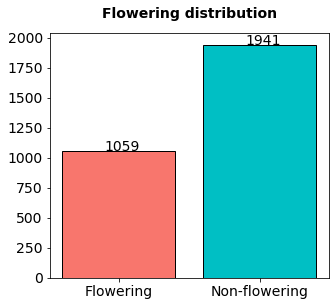

In [28]:
# Flowering
# Bar plot of flowering labels

# Data
positive = (df["Label_flowering"]== "Yes").sum()
negative = (df["Label_flowering"]== "No").sum()

x = ['Flowering', 'Non-flowering']
y = [positive, negative]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('Flowering distribution', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

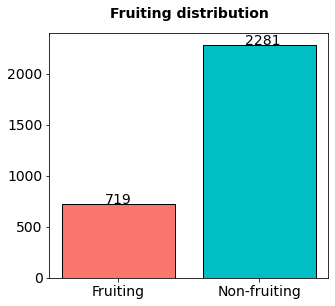

In [29]:
# Fruiting
# Bar plot of flowering labels

# Data
positive = (df["Label_fruiting"]== "Yes").sum()
negative = (df["Label_fruiting"]== "No").sum()

x = ['Fruiting', 'Non-fruiting']
y = [positive, negative]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('Fruiting distribution', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

### Field notes

In [30]:
# Remove stop words of different languages
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
stop_words = stpw.words("french") + stpw.words("english") + stpw.words("spanish") + stpw.words("portuguese")

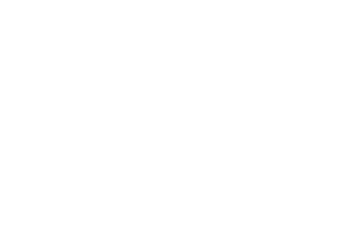

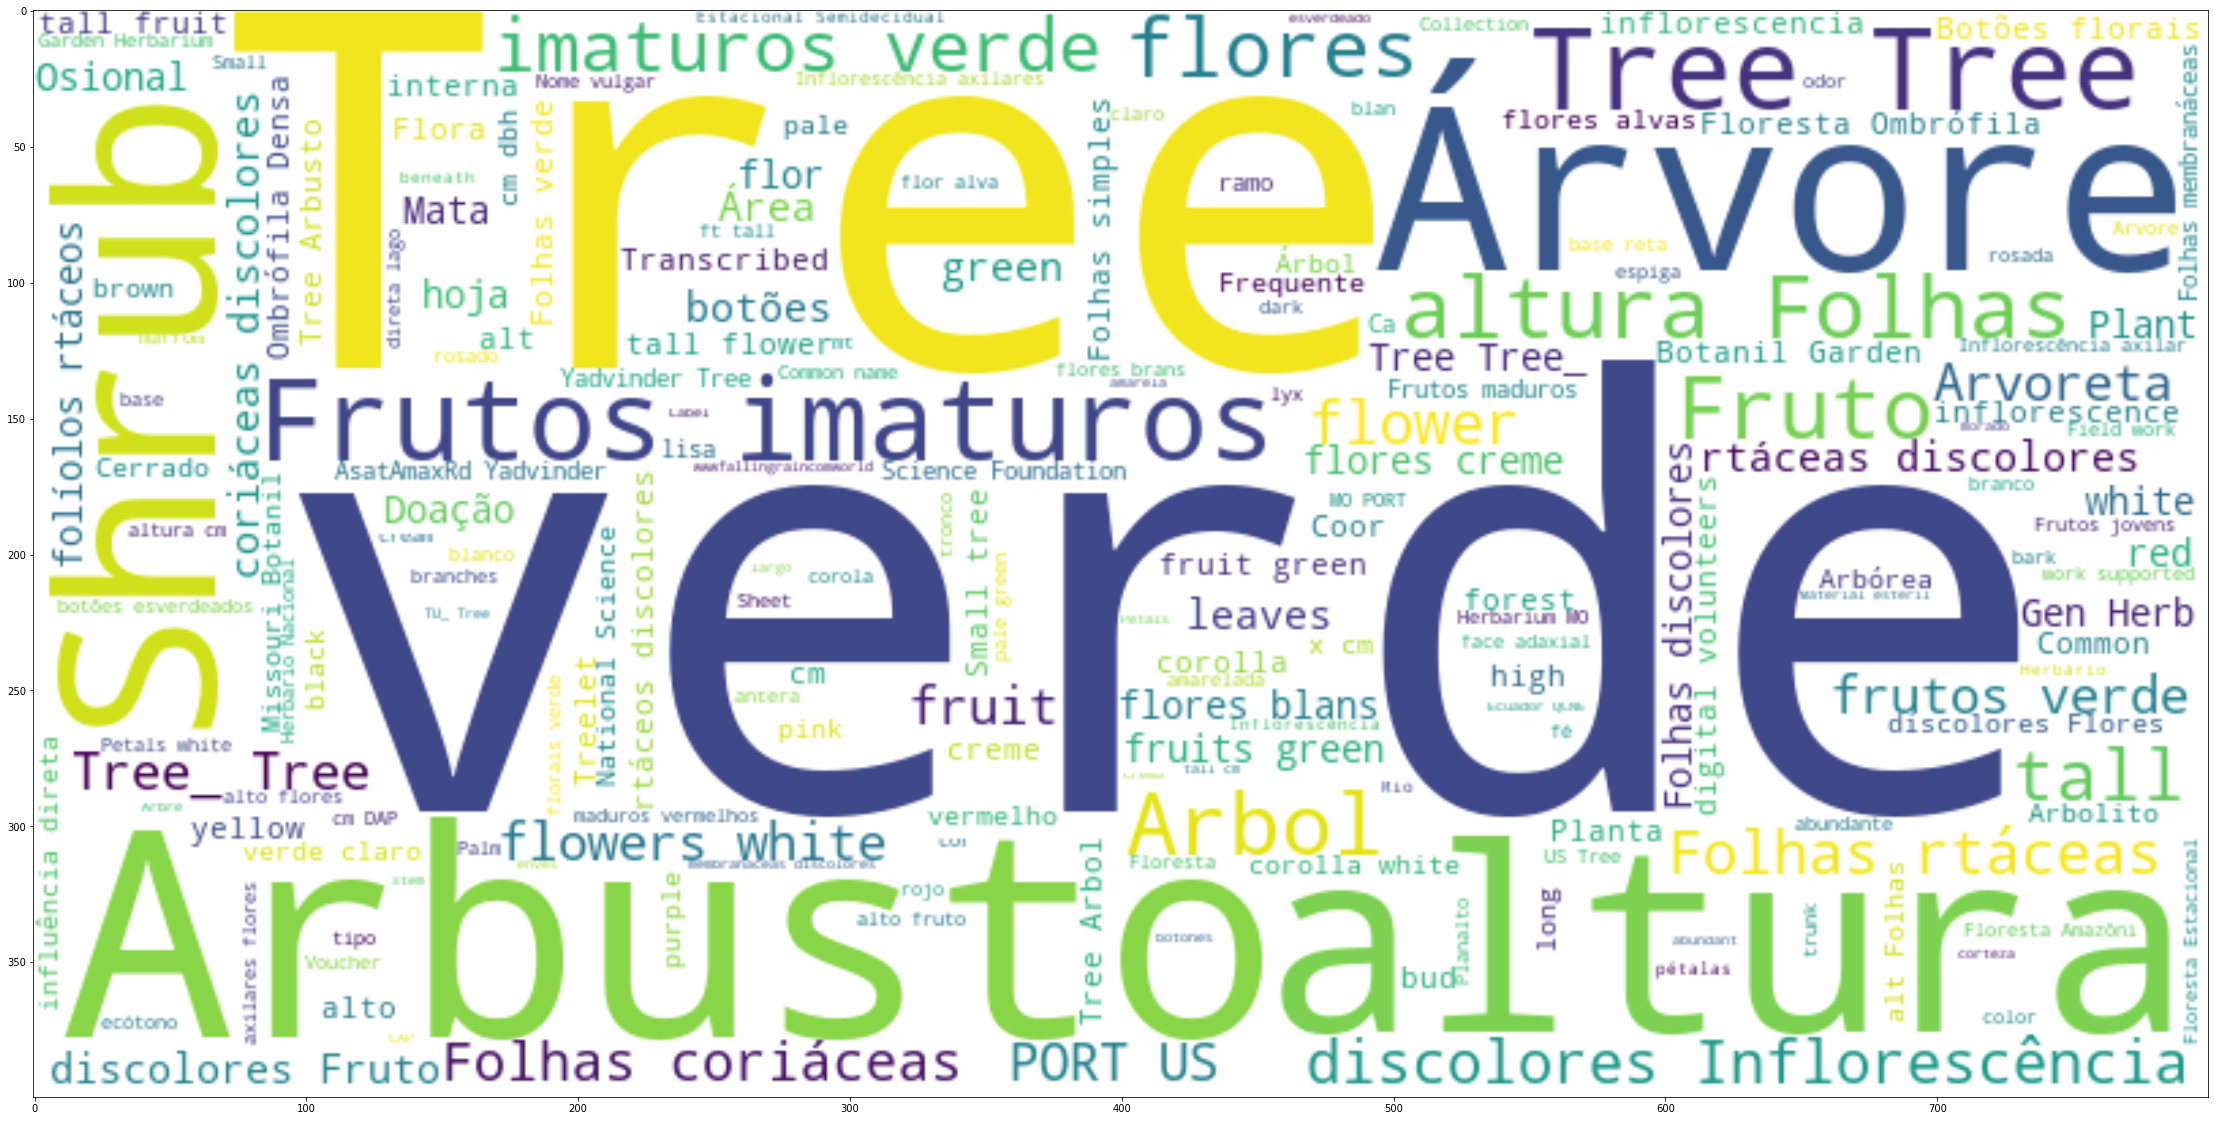

In [32]:
# WordCloud of field notes

# Text of all words in column bloom

text = " ".join(review for review in df.FieldNotes.astype(str))
#print ("There are {} words in the combination of all cells in column BLOOM.".format(len(text)))

# Create stopword list:
# remove words that we want to exclude
#stopwords.update(["bloom", "rose", "petals", "Average", "diameter","flushes", 'throughout', "Blooms", "form"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [33]:
wordcloud.words_

{'verde': 1.0,
 'Tree': 0.9911894273127754,
 'Arbusto': 0.9911894273127754,
 'altura': 0.8414096916299559,
 'Árvore': 0.8414096916299559,
 'Shrub': 0.7577092511013216,
 'Frutos imaturos': 0.7004405286343612,
 'Tree Tree': 0.7004405286343612,
 'altura Folhas': 0.6255506607929515,
 'Fruto': 0.6079295154185022,
 'Arbol': 0.5991189427312775,
 'flores': 0.5418502202643172,
 'imaturos verde': 0.5286343612334802,
 'tall': 0.4889867841409692,
 'discolores Inflorescência': 0.40969162995594716,
 'flower': 0.4008810572687225,
 'Folhas rtáceas': 0.3920704845814978,
 'Folhas coriáceas': 0.3832599118942731,
 'frutos verde': 0.3568281938325991,
 'fruit': 0.3436123348017621,
 'Tree_ Tree': 0.3392070484581498,
 'PORT US': 0.3392070484581498,
 'Arvoreta': 0.32599118942731276,
 'flowers white': 0.32158590308370044,
 'rtáceas discolores': 0.32158590308370044,
 'discolores Fruto': 0.30837004405286345,
 'leaves': 0.29955947136563876,
 'coriáceas discolores': 0.29955947136563876,
 'green': 0.2907488986784141

## Data preprocesing

Create the X and y variables for the RF models

In [102]:
# Define X and y
X = df['FieldNotes']
y_flow = df['Label_flowering']
y_fruit = df['Label_fruiting']

In [35]:
# Encoding the target variables
y_flow = y_flow.map({"Yes": 1, "No": 0})
y_fruit = y_fruit.map({"Yes": 1, "No": 0})

In [36]:
X.shape, y_flow.shape, y_fruit.shape

((3000,), (3000,), (3000,))

### Bag of words

Because most machine learning models operate on numbers (they're all just a bunch of mathematical operations), one of the main pre-processing steps is converting a piece of text into a set of numbers, which is called vectorisation.

One of the simplest vectorisation steps is splitting the text into individual words and counting up the how many times each word appears in each piece of text. This is called a "bag of words" because it's like throwing all the words in your training dataset into a bag.

This gives a matrix where each column is a word that appears in your training set, each row is an observation (here a specimen notes field), and each cell is the number of times a word appears in a particular observation.

`scikit-learn` has a simple implementation of this called `CountVectorizer`. This also has the advantage of doing some other simple pre-processing by default - it makes everything lower case, automatically removes words that appear in every single example, and removes punctuation. There are some other text processing things we might want to do at a later stage, but for now this will work as a starting point.

After creating the vectoriser, we fit it to our training data. This lets the vectoriser know what words are in our bag. We can fit it and transform our training data in a single step using `fit_transform`.

In [37]:
count_vct = CountVectorizer()
X_counts = count_vct.fit_transform(X.values)
X_counts.shape

(3000, 4295)

In [38]:
# Display some words
count_vct.get_feature_names_out()[1:100]

array(['_site_', '_site__endophytes', '_xd_', 'aau', 'abaixo',
       'abandoned', 'abaxial', 'abbott', 'abelhas', 'aberta', 'abertas',
       'abertura', 'abondant', 'abondante', 'about', 'above', 'abril',
       'abundancia', 'abundant', 'abundante', 'abundantes', 'abundantno',
       'ac', 'acc', 'accession', 'acerola', 'acetinodroma', 'achatado',
       'achatados', 'achutillo', 'acia', 'acinzentada', 'acinzentado',
       'acm', 'acre', 'across', 'actinodroma', 'acuminate', 'acumine',
       'acúmulo', 'adaxial', 'added', 'additional', 'ademia', 'adicional',
       'adjacente', 'admin', 'administration', 'adocido', 'adulta',
       'adultas', 'afce', 'aff', 'aflor', 'afloramento', 'afloramentos',
       'afloramiento', 'after', 'agallas', 'age', 'ago', 'agostini',
       'agosto', 'agradable', 'agradavel', 'agradável', 'agricultura',
       'agriculture', 'agrietada', 'agrnômico', 'agronomico',
       'agronômico', 'agropecuária', 'agrupados', 'ahe', 'ainda', 'air',
       'ajou',

In [39]:
# Remove stop words of different languages
count_vct_stops = CountVectorizer(stop_words=stop_words)

X_counts_stop = count_vct_stops.fit_transform(X.values)
X_counts_stop.shape

(3000, 4129)

In [40]:
# Display some words
count_vct_stops.get_feature_names_out()[1:100]

array(['_site_', '_site__endophytes', '_xd_', 'aau', 'abaixo',
       'abandoned', 'abaxial', 'abbott', 'abelhas', 'aberta', 'abertas',
       'abertura', 'abondant', 'abondante', 'abril', 'abundancia',
       'abundant', 'abundante', 'abundantes', 'abundantno', 'ac', 'acc',
       'accession', 'acerola', 'acetinodroma', 'achatado', 'achatados',
       'achutillo', 'acia', 'acinzentada', 'acinzentado', 'acm', 'acre',
       'across', 'actinodroma', 'acuminate', 'acumine', 'acúmulo',
       'adaxial', 'added', 'additional', 'ademia', 'adicional',
       'adjacente', 'admin', 'administration', 'adocido', 'adulta',
       'adultas', 'afce', 'aff', 'aflor', 'afloramento', 'afloramentos',
       'afloramiento', 'agallas', 'age', 'ago', 'agostini', 'agosto',
       'agradable', 'agradavel', 'agradável', 'agricultura',
       'agriculture', 'agrietada', 'agrnômico', 'agronomico',
       'agronômico', 'agropecuária', 'agrupados', 'ahe', 'ainda', 'air',
       'ajou', 'akoki', 'alabama', 'alara

## Machine learning models

We can use our bag of words as input to machine learning models.

We'll try a simple naive bayes to start with.

In [41]:
# Function to store performance metrics results
def format_cv_results(results, model_name="model"):
  results_df = (
    pd.DataFrame(results)
      .rename(columns=lambda x: x.replace("test_", ""))
      .assign(model=model_name,
              fold=lambda df: df.index.values)
      .drop(columns=["fit_time", "score_time"])
  )

  return results_df

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

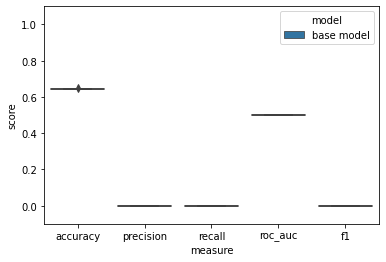

In [43]:
# Base line model for flowering
simple_clf = DummyClassifier(strategy="most_frequent", random_state=123)

basemod_scores_fl = cross_validate(simple_clf, X_counts_stop, y_flow, cv=5, scoring=["accuracy", "precision", "recall", "roc_auc", "f1"])

cv_results_fl = format_cv_results(basemod_scores_fl, "base model").melt(id_vars=["model", "fold"], var_name="measure", value_name="score")

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results_fl, ax=ax)

ax.set_ylim((-0.1, 1.1));

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

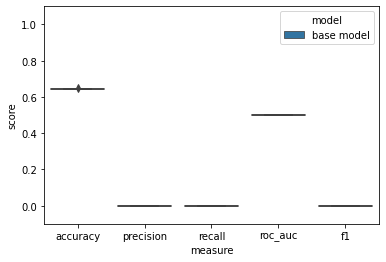

In [44]:
# Base line model for fruiting
simple_clf = DummyClassifier(strategy="most_frequent", random_state=123)

basemod_scores_fr = cross_validate(simple_clf, X_counts_stop, y_fruit, cv=5, scoring=["accuracy", "precision", "recall", "roc_auc", "f1"])

cv_results_fr = format_cv_results(basemod_scores_fl, "base model").melt(id_vars=["model", "fold"], var_name="measure", value_name="score")

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results_fr, ax=ax)

ax.set_ylim((-0.1, 1.1));

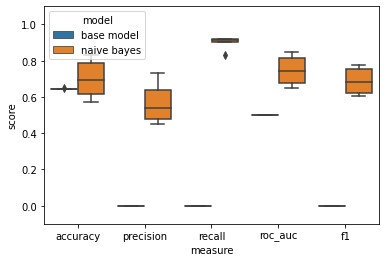

In [45]:
# NB model for flowering
nb_clf_fl = GaussianNB()

nb_scores_fl = cross_validate(nb_clf_fl, X_counts_stop.toarray(), y_flow, cv=5, scoring=["accuracy", "precision", "recall", "roc_auc", "f1"])

cv_results_fl = (
    pd.concat([format_cv_results(basemod_scores_fl, "base model"),
               format_cv_results(nb_scores_fl, "naive bayes"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results_fl, ax=ax)

ax.set_ylim((-0.1, 1.1));

In [46]:
results_sum_fl = cv_results_fl.groupby(['model', 'measure']).agg([np.mean, np.std])

In [47]:
results_sum_fl = results_sum_fl.drop(columns=["fold"])

In [48]:
results_sum_fl

score          
                           mean       std
model       measure                      
base model  accuracy   0.647000  0.000745
            f1         0.000000  0.000000
            precision  0.000000  0.000000
            recall     0.000000  0.000000
            roc_auc    0.500000  0.000000
naive bayes accuracy   0.701000  0.109713
            f1         0.687601  0.076339
            precision  0.567268  0.116661
            recall     0.897089  0.038187
            roc_auc    0.747767  0.085144

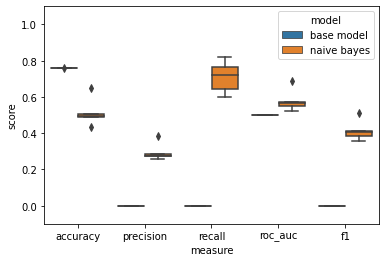

In [49]:
# NB model for fruiting
nb_clf_fr = GaussianNB()

nb_scores_fr = cross_validate(nb_clf_fr, X_counts_stop.toarray(), y_fruit, cv=5, scoring=["accuracy", "precision", "recall", "roc_auc", "f1"])

cv_results_fr = (
    pd.concat([format_cv_results(basemod_scores_fr, "base model"),
               format_cv_results(nb_scores_fr, "naive bayes"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results_fr, ax=ax)

ax.set_ylim((-0.1, 1.1));

In [50]:
results_sum_fr = cv_results_fr.groupby(['model', 'measure']).agg([np.mean, np.std])

In [51]:
results_sum_fr = results_sum_fr.drop(columns=["fold"])

In [52]:
results_sum_fr

score          
                           mean       std
model       measure                      
base model  accuracy   0.760333  0.000745
            f1         0.000000  0.000000
            precision  0.000000  0.000000
            recall     0.000000  0.000000
            roc_auc    0.500000  0.000000
naive bayes accuracy   0.515000  0.080803
            f1         0.414377  0.058970
            precision  0.294381  0.052145
            recall     0.709227  0.089706
            roc_auc    0.581486  0.063530

And then we can try a random forest model. Typically this might need some parameter tuning, but usually works well out of the box.


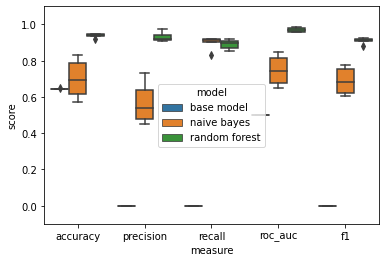

In [53]:
# RF model for flowering
rf_clf_fl = RandomForestClassifier()

# Train the model
rf_clf_fl.fit(X_counts_stop, y_flow)

rf_scores_fl = cross_validate(rf_clf_fl, X_counts_stop.toarray(), y_flow, cv=5, scoring=["accuracy", "precision", "recall", "roc_auc", "f1"])

cv_results_fl = (
    pd.concat([format_cv_results(basemod_scores_fl, "base model"),
               format_cv_results(nb_scores_fl, "naive bayes"),
               format_cv_results(rf_scores_fl, "random forest"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results_fl, ax=ax)

ax.set_ylim((-0.1, 1.1));

In [54]:
results_sum_fl = cv_results_fl.groupby(['model', 'measure']).agg([np.mean, np.std])

In [55]:
results_sum_fl = results_sum_fl.drop(columns=["fold"])

In [56]:
results_sum_fl

score          
                             mean       std
model         measure                      
base model    accuracy   0.647000  0.000745
              f1         0.000000  0.000000
              precision  0.000000  0.000000
              recall     0.000000  0.000000
              roc_auc    0.500000  0.000000
naive bayes   accuracy   0.701000  0.109713
              f1         0.687601  0.076339
              precision  0.567268  0.116661
              recall     0.897089  0.038187
              roc_auc    0.747767  0.085144
random forest accuracy   0.937667  0.011093
              f1         0.909652  0.016428
              precision  0.931568  0.026346
              recall     0.889524  0.027997
              roc_auc    0.971143  0.011935

In [ ]:
# Export performance metrics
results_sum_fl.to_csv('performance_metrics_flowering.csv')

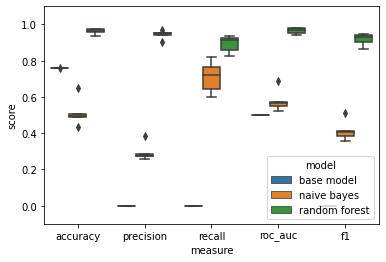

In [58]:
# RF model for fruiting
rf_clf_fr = RandomForestClassifier()

rf_scores_fr = cross_validate(rf_clf_fr, X_counts_stop.toarray(), y_fruit, cv=5, scoring=["accuracy", "precision", "recall", "roc_auc", "f1"])

cv_results_fr = (
    pd.concat([format_cv_results(basemod_scores_fr, "base model"),
               format_cv_results(nb_scores_fr, "naive bayes"),
               format_cv_results(rf_scores_fr, "random forest"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results_fr, ax=ax)

ax.set_ylim((-0.1, 1.1));

In [59]:
results_sum_fr = cv_results_fr.groupby(['model', 'measure']).agg([np.mean, np.std])

In [60]:
results_sum_fr = results_sum_fr.drop(columns=["fold"])

In [61]:
results_sum_fr

score          
                             mean       std
model         measure                      
base model    accuracy   0.760333  0.000745
              f1         0.000000  0.000000
              precision  0.000000  0.000000
              recall     0.000000  0.000000
              roc_auc    0.500000  0.000000
naive bayes   accuracy   0.515000  0.080803
              f1         0.414377  0.058970
              precision  0.294381  0.052145
              recall     0.709227  0.089706
              roc_auc    0.581486  0.063530
random forest accuracy   0.961667  0.015723
              f1         0.917460  0.034912
              precision  0.943902  0.025764
              recall     0.892949  0.047167
              roc_auc    0.967070  0.017401

In [ ]:
 # Export performance metrics
 results_sum_fr.to_csv('performance_metrics_fruiting.csv')

In [100]:
# Create a pipeline to store the best models 
rf_pipe1 = Pipeline([("vect", CountVectorizer(stop_words=stop_words)), ("clf", RandomForestClassifier())
])

rf_pipe2 = Pipeline([("vect", CountVectorizer(stop_words=stop_words)), ("clf", RandomForestClassifier())
])

In [103]:
# Fit the final flowering model 
rf_flow_def = rf_pipe1.fit(X.values, y_flow)

In [104]:
# Fit the final fruiting model 
rf_fruit_def = rf_pipe2.fit(X.values, y_fruit)

In [82]:
# Export th best RF model for flowering
# Define the output file's name
output_file = f'RandomForest_flowering_nestimators100.bin'
output_file

'RandomForest_flowering_nestimators100.bin'

In [105]:
with open(output_file, "wb") as f_out:
    pickle.dump(rf_flow_def, f_out)

In [106]:
# Export th best RF model for flowering
# Define the output file's name
output_file2 = f'RandomForest_fruiting_nestimators100.bin'
output_file2

'RandomForest_fruiting_nestimators100.bin'

In [107]:
with open(output_file2, "wb") as f_out:
    pickle.dump(rf_fruit_def, f_out)

### Feature importance

One nice thing about random forest classifiers is we can use feature importance to get an idea of which words are most important to the performance of the classifier.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


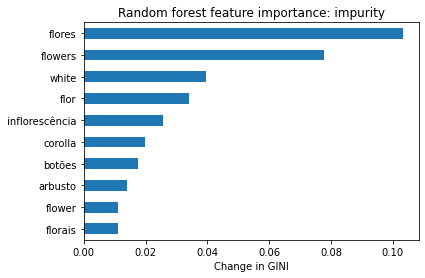

In [ ]:
# Flowering RF
rf_clf_fl.fit(X_counts_stop.toarray(), y_flow)

fig, ax = plt.subplots()
pd.Series(rf_clf_fl.feature_importances_, index=count_vct_stops.get_feature_names()).sort_values(ascending=False).head(10).plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_xlabel("Change in GINI")
ax.set_title("Random forest feature importance: impurity");

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


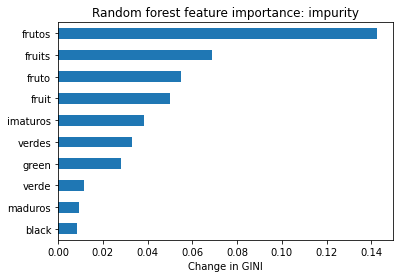

In [ ]:
# Fruiting RF
rf_clf_fr.fit(X_counts_stop.toarray(), y_fruit)

fig, ax = plt.subplots()
pd.Series(rf_clf_fr.feature_importances_, index=count_vct_stops.get_feature_names()).sort_values(ascending=False).head(10).plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_xlabel("Change in GINI")
ax.set_title("Random forest feature importance: impurity");

## Evaluating the performance of the mdoel with a test dataset

In [ ]:
rf_pipe = Pipeline([("vect", CountVectorizer()), ("clf", RandomForestClassifier())
])

In [ ]:
cv = KFold(n_splits=5, shuffle=True)

In [ ]:
[(train.shape, test.shape) for (train, test) in cv.split(X)]

[((2400,), (600,)),
 ((2400,), (600,)),
 ((2400,), (600,)),
 ((2400,), (600,)),
 ((2400,), (600,))]

In [ ]:
# Evaluation for RF flowering
scores_fl = []
for train_idx, test_idx in cv.split(X):
  X_train, X_test = X.values[train_idx], X.values[test_idx]
  y_train, y_test = y_flow[train_idx], y_flow[test_idx]
  fit = rf_pipe.fit(X_train, y_train)
  pred = fit.predict(X_test)
  scores_fl.append({
      "accuracy": accuracy_score(y_test, pred),
      "precision": precision_score(y_test, pred),
      "recall": recall_score(y_test, pred),
      "roc_auc": roc_auc_score(y_test, pred),
      "f1_score": f1_score(y_test, pred),
  })

pd.DataFrame(scores_fl)

,accuracy,precision,recall,roc_auc,f1_score
0,0.936667,0.893519,0.927885,0.934606,0.910377
1,0.941667,0.943878,0.885167,0.928517,0.913580
2,0.953333,0.956757,0.898477,0.939313,0.926702
3,0.935000,0.933014,0.886364,0.924761,0.909091
4,0.945000,0.948598,0.902222,0.936444,0.924829


In [ ]:
# Evaluation for RF fruiting
scores_fr = []
for train_idx, test_idx in cv.split(X):
  X_train, X_test = X.values[train_idx], X.values[test_idx]
  y_train, y_test = y_fruit[train_idx], y_fruit[test_idx]
  fit = rf_pipe.fit(X_train, y_train)
  pred = fit.predict(X_test)
  scores_fr.append({
      "accuracy": accuracy_score(y_test, pred),
      "precision": precision_score(y_test, pred),
      "recall": recall_score(y_test, pred),
      "roc_auc": roc_auc_score(y_test, pred),
      "f1_score": f1_score(y_test, pred),
  })

pd.DataFrame(scores_fr)

,accuracy,precision,recall,roc_auc,f1_score
0,0.958333,0.895833,0.928058,0.947760,0.911661
1,0.963333,0.941606,0.902098,0.942296,0.921429
2,0.958333,0.955224,0.870748,0.928752,0.911032
3,0.958333,0.965278,0.874214,0.931438,0.917492
4,0.966667,0.937008,0.908397,0.945670,0.922481
